Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from requests import get
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from scipy.stats.stats import pearsonr
from scipy.stats.mstats import winsorize
import folium
from folium.plugins import HeatMap

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Read CSV

In [3]:
north_america_0 = pd.read_csv('/content/drive/My Drive/Omdena/Data/TrashOut/northamerica_0.csv', error_bad_lines=False, delimiter=';')
north_america_1 = pd.read_csv('/content/drive/My Drive/Omdena/Data/TrashOut/northamerica_1.csv', error_bad_lines=False, delimiter=';')

Concatenate the dataframes into a single one

In [4]:
north_america = pd.concat([north_america_0, north_america_1]).reset_index(drop=True)

In [5]:
north_america.head()

,id,latitude,longitude,continent,country,aa1,aa2,aa3,locality,subLocality,types,updateTime,updateNeeded,note,url,status,size,anonymous,created,accessibility,image
0,57821,50.902838,-119.579705,North America,Canada,British Columbia,Columbia-Shuswap,Columbia-Shuswap F,Lee Creek,Lee Creek,domestic,2020-06-21T17:59:35.703Z,False,just near the mailboxes down the bank.,https://admin.trashout.ngo/trash-management/de...,stillHere,car,False,2020-06-21T17:59:35.703Z,byCar,https://firebasestorage.googleapis.com/v0/b/tr...
1,57802,49.895350,-125.248711,North America,Canada,British Columbia,Strathcona,Comox-Strathcona D,Campbell River,Campbell River,"metal,domestic",2020-06-18T23:53:10.907Z,False,NaN,https://admin.trashout.ngo/trash-management/de...,stillHere,bag,False,2020-06-18T23:53:10.907Z,"byCar, underWater",https://firebasestorage.googleapis.com/v0/b/tr...
2,57768,49.679616,-125.133810,North America,Canada,British Columbia,Comox Valley,Comox-Strathcona C,NaN,Comox-Strathcona C,construction,2020-06-16T17:35:40.276Z,False,NaN,https://admin.trashout.ngo/trash-management/de...,stillHere,wheelbarrow,False,2020-06-16T17:35:40.276Z,NaN,https://firebasestorage.googleapis.com/v0/b/tr...
3,57757,49.523775,-124.855999,North America,Canada,British Columbia,Comox Valley,Comox-Strathcona A,Fanny Bay,Fanny Bay,construction,2020-06-18T15:47:48.587Z,False,NaN,https://admin.trashout.ngo/trash-management/de...,cleaned,car,False,2020-06-14T18:32:00.280Z,NaN,https://firebasestorage.googleapis.com/v0/b/tr...
4,57707,49.515675,-124.848629,North America,Canada,British Columbia,Comox Valley,Comox-Strathcona A,Fanny Bay,Fanny Bay,domestic,2020-06-14T18:11:44.191Z,False,NaN,https://admin.trashout.ngo/trash-management/de...,cleaned,car,False,2020-06-13T17:44:12.239Z,byCar,https://firebasestorage.googleapis.com/v0/b/tr...


Filter dataset to only United States

In [6]:
usa = north_america[north_america['country'] == 'United States']

In [10]:
print(usa.shape)
usa.head()

(3645, 21)


,id,latitude,longitude,continent,country,aa1,aa2,aa3,locality,subLocality,types,updateTime,updateNeeded,note,url,status,size,anonymous,created,accessibility,image
5,57660,39.600342,-79.908381,North America,United States,West Virginia,Monongalia County,Eastern,Morgantown,Morgantown,"dangerous,plastic,construction",2020-06-12T17:33:21.201Z,False,"It's not exactly 15 Marie Ln, but it is two lo...",https://admin.trashout.ngo/trash-management/de...,stillHere,car,False,2020-06-12T17:33:21.201Z,byCar,https://firebasestorage.googleapis.com/v0/b/tr...
11,57504,34.279684,-83.838919,North America,United States,Georgia,Hall County,NaN,Gainesville,Gainesville,"electronic,construction,domestic",2020-05-27T15:34:22.892Z,False,another dumping at the salvation army fences.,https://admin.trashout.ngo/trash-management/de...,stillHere,car,False,2020-05-27T15:34:22.892Z,NaN,https://firebasestorage.googleapis.com/v0/b/tr...
15,57442,34.000155,-118.429591,North America,United States,California,Los Angeles County,NaN,Los Angeles,Culver - West,electronic,2020-05-21T19:57:29.084Z,False,NaN,https://admin.trashout.ngo/trash-management/de...,stillHere,car,True,2020-05-21T19:57:29.084Z,byCar,https://firebasestorage.googleapis.com/v0/b/tr...
16,57441,34.279761,-83.840134,North America,United States,Georgia,Hall County,NaN,Gainesville,Gainesville,domestic,2020-05-21T18:21:50.884Z,False,We closed our store and people have been dumpi...,https://admin.trashout.ngo/trash-management/de...,stillHere,car,False,2020-05-21T18:21:50.884Z,NaN,https://firebasestorage.googleapis.com/v0/b/tr...
55,57148,39.942648,-75.365277,North America,United States,Pennsylvania,Delaware County,Marple Township,Media,NaN,automotive,2020-04-28T17:16:52.796Z,False,car tire,https://admin.trashout.ngo/trash-management/de...,more,wheelbarrow,False,2020-04-28T17:15:55.865Z,"byCar, notForGeneralCleanup",https://firebasestorage.googleapis.com/v0/b/tr...


Only keep columns relevant to the analysis

In [11]:
columns = ['id', 'latitude', 'longitude', 'continent', 'country', 'aa1', 'aa2']
usa = usa[columns]

Check for null values

In [14]:
pd.DataFrame(usa.isnull().sum()*100/len(usa), columns=['% Missing Values']).sort_values(by='% Missing Values', ascending=False)

,% Missing Values
aa2,1.563786
id,0.000000
latitude,0.000000
longitude,0.000000
continent,0.000000
country,0.000000
aa1,0.000000


The aa2 variable corresponds to the county. For the USA, only 1.56% of the county names are missing, so it's safe to drop the missing ones.

In [17]:
usa = usa.dropna(subset=['aa2'])
print(usa.shape)

(3588, 7)


In [18]:
usa

,id,latitude,longitude,continent,country,aa1,aa2
5,57660,39.600342,-79.908381,North America,United States,West Virginia,Monongalia County
11,57504,34.279684,-83.838919,North America,United States,Georgia,Hall County
15,57442,34.000155,-118.429591,North America,United States,California,Los Angeles County
16,57441,34.279761,-83.840134,North America,United States,Georgia,Hall County
55,57148,39.942648,-75.365277,North America,United States,Pennsylvania,Delaware County
...,...,...,...,...,...,...,...
6350,526,39.181358,-76.733360,North America,United States,Maryland,Anne Arundel
6351,517,39.181732,-76.732323,North America,United States,Maryland,Anne Arundel
6352,505,39.183693,-76.729805,North America,United States,Maryland,Anne Arundel
6353,500,47.660908,-122.319984,North America,United States,Washington,King County


Function to query population density by county from U.S. Census Bureau

Link to website: https://www.census.gov/quickfacts/fact/table/

In [35]:
def get_population_density(county, state):
  county_state = county.lower().replace(' ', '').strip() + state.lower().replace(' ', '').strip()
  url = f'https://www.census.gov/quickfacts/fact/table/{county_state}/POP060210'
  response = get(url)
  html_soup = BeautifulSoup(response.text, 'html.parser')
  facts_table = html_soup.find_all('tbody')
  population_density = facts_table[-1].text.split('Population per square mile, 2010\n\n\n')[1].split('\n\n\n\n')[0]
  return float(population_density.replace(',', ''))

Group records by county

In [36]:
usa['reports'] = 1
usa['pop_density'] = np.nan

In [37]:
usa

,id,latitude,longitude,continent,country,aa1,aa2,reports,pop_density
5,57660,39.600342,-79.908381,North America,United States,West Virginia,Monongalia County,1,NaN
11,57504,34.279684,-83.838919,North America,United States,Georgia,Hall County,1,NaN
15,57442,34.000155,-118.429591,North America,United States,California,Los Angeles County,1,NaN
16,57441,34.279761,-83.840134,North America,United States,Georgia,Hall County,1,NaN
55,57148,39.942648,-75.365277,North America,United States,Pennsylvania,Delaware County,1,NaN
...,...,...,...,...,...,...,...,...,...
6350,526,39.181358,-76.733360,North America,United States,Maryland,Anne Arundel,1,NaN
6351,517,39.181732,-76.732323,North America,United States,Maryland,Anne Arundel,1,NaN
6352,505,39.183693,-76.729805,North America,United States,Maryland,Anne Arundel,1,NaN
6353,500,47.660908,-122.319984,North America,United States,Washington,King County,1,NaN


In [38]:
usa_county = usa.groupby(by=['aa1','aa2']).agg('count')[['reports', 'pop_density']]
usa_county

reports  pop_density
aa1       aa2                                   
Arizona   Maricopa County         1            0
          Mohave County           1            0
          Pima County             1            0
          Pinal County            1            0
          Yavapai County          2            0
...                             ...          ...
Wisconsin Grant County            1            0
          Milwaukee County        1            0
          Rock County             1            0
          Sauk County             1            0
Wyoming   Park County             1            0

[217 rows x 2 columns]

In [39]:
pop_density = []
# use tqdm to show the progress bar 1 --> 100%
for i in tqdm(range(0,len(usa_county.index))):
  county = usa_county.index[i][1]
  state = usa_county.index[i][0]
  pop_density.append(get_population_density(county, state))

Add population density to dataframe

In [40]:
usa_county['pop_density'] = pop_density

In [41]:
usa_county

reports  pop_density
aa1       aa2                                   
Arizona   Maricopa County         1        414.9
          Mohave County           1         15.0
          Pima County             1        106.7
          Pinal County            1         70.0
          Yavapai County          2         26.0
...                             ...          ...
Wisconsin Grant County            1         44.7
          Milwaukee County        1       3926.0
          Rock County             1        223.3
          Sauk County             1         74.6
Wyoming   Park County             1          4.1

[217 rows x 2 columns]

Pearson Product-Moment Correlation Coefficients (with outliers)

In [42]:
np.corrcoef(usa_county['reports'], usa_county['pop_density'])[0,1]

0.013643253657701724

The coefficient of correlation seems to be very low. It's important to mention that at this moment, there could be outliers on the data.

Plot scatterplot (with outliers)

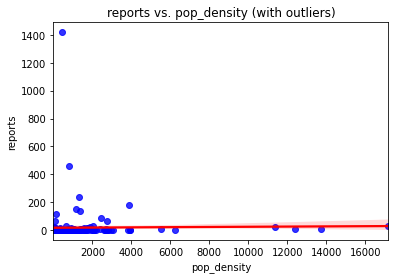

In [43]:
sns.regplot(x="pop_density", y="reports", data=usa_county, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title('reports vs. pop_density (with outliers)')
plt.show()

Remove outliers from reports using  Winsorization

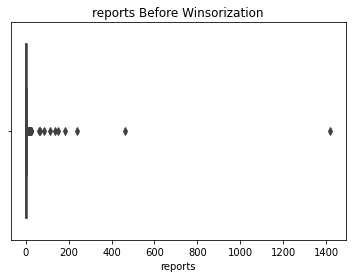

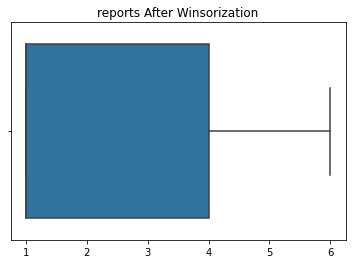

In [44]:
#Before winsorization
sns.boxplot(usa_county['reports'])
plt.title("reports Before Winsorization")
plt.show()

#Winsorization
winsorized_reports = winsorize(usa_county['reports'],(0, 0.15))

#After winsorization
sns.boxplot(winsorized_reports)
plt.title("reports After Winsorization")
plt.show()

In [45]:
usa_county['reports'] = winsorized_reports

Remove outliers from population density

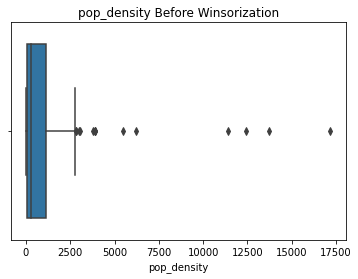

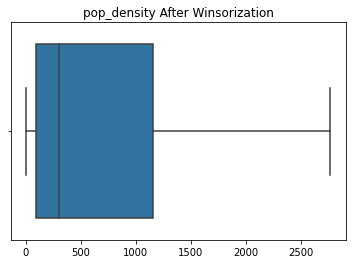

In [46]:
#Before winsorization
sns.boxplot(usa_county['pop_density'])
plt.title("pop_density Before Winsorization")
plt.show()

#Winsorization
winsorized_pop_density = winsorize(usa_county['pop_density'],(0, 0.065))

#After winsorization
sns.boxplot(winsorized_pop_density)
plt.title("pop_density After Winsorization")
plt.show()

In [47]:
usa_county['pop_density'] = winsorized_pop_density

Pearson Product-Moment Correlation Coefficients (without outliers)

In [48]:
np.corrcoef(usa_county['reports'], usa_county['pop_density'])[0,1]

0.23596324264282256

Plot scatterplot (without outliers)

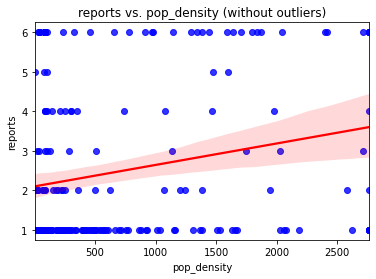

In [49]:
sns.regplot(x="pop_density", y="reports", data=usa_county, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title('reports vs. pop_density (without outliers)')
plt.show()

### Plot Heatmap

In [50]:
avg_latitude = usa['latitude'].mean()
avg_longitude = usa['longitude'].mean()

In [51]:
coordinates = list(zip(usa['latitude'], usa['longitude']))

In [52]:
usa_map = folium.Map(location=[avg_latitude, avg_longitude], zoom_start = 4)

In [53]:
HeatMap(coordinates).add_to(folium.FeatureGroup(name='Heat Map').add_to(usa_map))
folium.LayerControl().add_to(usa_map)

In [54]:
usa_map